In [24]:
# Standard library
import os
import sys
import re
import json
import pickle
import glob
import ast
import warnings
from pathlib import Path
import importlib

# Add custom path
sys.path.append('/root/capsule/code/beh_ephys_analysis')

# Scientific libraries
import numpy as np
print(np.__version__)
import pandas as pd
print(pd.__version__)
import xarray as xr
import scipy.signal as signal
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# SpikeInterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw

# Progress bar
from tqdm import tqdm
import seaborn as sns
from trimesh import load_mesh

# IPython display
from IPython.display import clear_output

# Open Ephys
from open_ephys.analysis import Session

# AIND analysis and utils
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from aind_ephys_utils import align, sort

# Local utilities
import utils.analysis_funcs as af
import utils.plotting_funcs as pf
from utils.beh_functions import session_dirs
from utils.combine_tools import apply_qc
from utils.ccf_utils import pir_to_lps
# from utils.plot_utils import shiftedColorMap, template_reorder, plot_raster_bar, merge_pdfs

# Warnings
warnings.filterwarnings("ignore")

# Matplotlib inline for Jupyter
%matplotlib inline

# Confirm version
print(si.__version__)
print('Finished loading packages')

2.1.3
2.3.1
0.102.1
Finished loading packages


# Load data

In [25]:
criteria_name = 'basic_ephys_low'

In [26]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
    
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

In [27]:
combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)

Applying bounds for isi_violations: [0.0, 0.5]
 - isi_violations: 17847 -> 11408 units passed
Applying items for qc_pass: [True]
 - qc_pass: 11408 -> 8366 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 8366 -> 8330 units passed
Applying conditional bounds for y_loc
 - y_loc: 8330 -> 6173 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']


In [ ]:
session_list = combined_tagged_units_filtered[combined_tagged_units_filtered['probe']=='2']['session'].unique().tolist()

In [ ]:
concatenate_antidromic_results_all = []
for session in session_list:
    session_dir = session_dirs(session)
    save_dir = os.path.join(session_dir['opto_dir_curated'], f'{session}_antidromic_results.pkl')
    if os.path.exists(save_dir):
        with open(save_dir, 'rb') as f:
            merged_df = pickle.load(f)
        merged_df['session'] = session
        concatenate_antidromic_results_all.append(merged_df)

In [ ]:
concatenate_antidromic_results = pd.concat(concatenate_antidromic_results_all, ignore_index=True)

# concatenate_antidromic_results.to_pickle(os.path.join(results_folder, 'concatenate_antidromic_results.pkl'))
concatenate_antidromic_results.rename(columns={'unit_id': 'unit'}, inplace=True)
# concatenate_antidromic_results.rename(columns={'session_id': 'session'}, inplace=True)


In [ ]:

# select target
focus = 'S1'
cols_to_keep = [
    col for col in concatenate_antidromic_results.columns
    if col[1] in (f'surface_{focus}', '')  # keep both surface_PrL and no-site columns
]
df_focus = concatenate_antidromic_results.loc[:, cols_to_keep]
if isinstance(df_focus.columns, pd.MultiIndex):
    df_focus.columns = df_focus.columns.get_level_values(0)

combined_df = combined_tagged_units_filtered.merge(df_focus, on=['session', 'unit'], how='inner')


In [ ]:
combined_df_clean = combined_df[[c for c in combined_df.columns 
               if combined_df[c].dropna().map(lambda x: isinstance(x, (str, int, float, np.number, bool))).all()]]


In [ ]:
combined_df['p_auto_inhi_log'] = -np.log10(combined_df['p_auto_inhi'] + 1e-20)
combined_df['p_collision_log'] = -np.log10(combined_df['p_collision'] + 1e-20)
combined_df['p_antidromic_log'] = -np.log10(combined_df['p_antidromic'] + 1e-20)

In [ ]:
combined_df[['session', 'unit', 'antidromic_latency', 'jitter', 'opto_p_val', 'p_antidromic', 'collision_pvalue', 'p_collision', 't_collision','p_auto_inhi']]

,session,unit,antidromic_latency,jitter,opto_p_val,p_antidromic,collision_pvalue,p_collision,t_collision,p_auto_inhi
0,ecephys_713854_2024-03-05_12-01-40,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ecephys_713854_2024-03-05_12-01-40,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ecephys_713854_2024-03-05_12-01-40,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ecephys_713854_2024-03-05_13-01-09,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ecephys_713854_2024-03-05_13-01-09,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
361,behavior_791691_2025-06-27_13-54-30,366,0.0400,0.0010,1.827407e-25,4.530235e-89,7.060644e-04,1.028444e-46,-15.131661,0.265881
362,behavior_784803_2025-07-02_13-41-41,27,0.0325,0.0030,1.267265e-19,5.110842e-225,1.595270e-11,1.256312e-112,-25.771357,0.272278
363,behavior_784803_2025-07-02_13-41-41,32,0.0130,0.0335,1.025663e-09,1.670950e-17,1.000000e+00,6.120357e-01,-0.507330,0.007706
364,behavior_784803_2025-07-02_13-41-41,37,0.0170,0.0225,1.971283e-12,2.908229e-24,7.254188e-01,1.730716e-01,-1.363378,0.611297


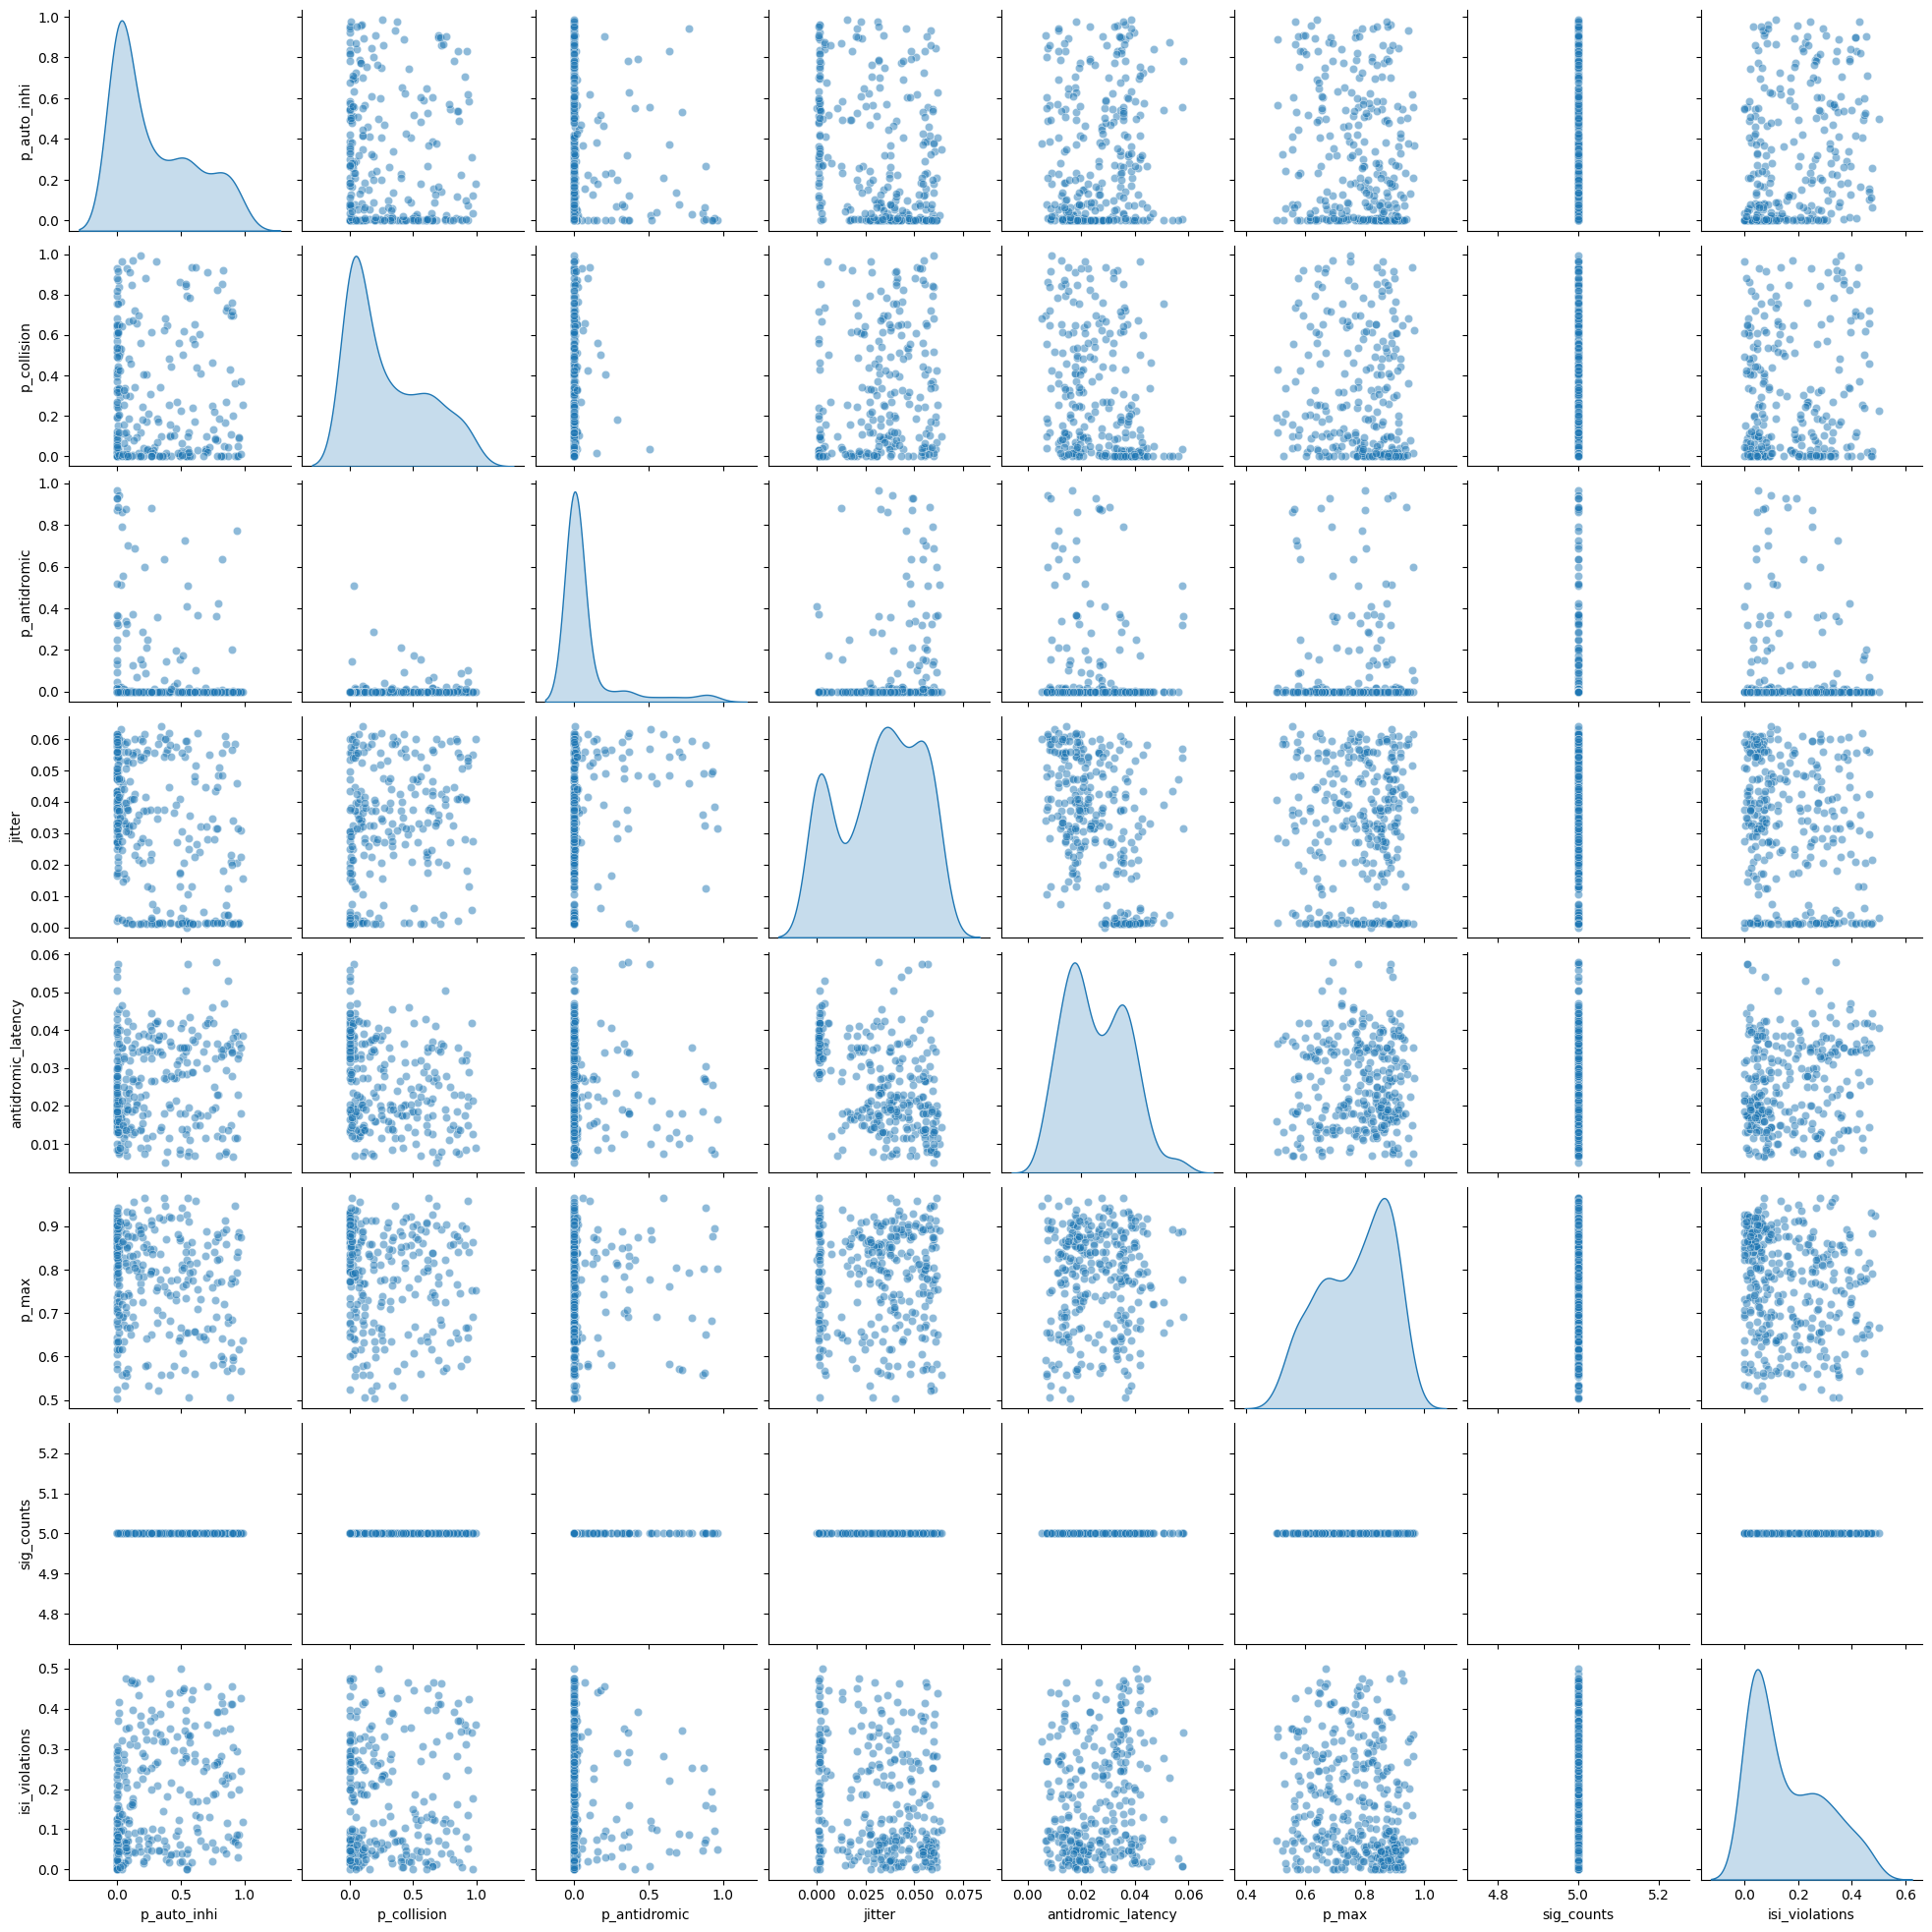

In [ ]:
col_to_plot = ['p_auto_inhi', 'p_collision', 'p_antidromic', 'jitter', 'antidromic_latency',
                'p_max', 'sig_counts',
                'isi_violations']
sns.pairplot(combined_df[col_to_plot], vars=col_to_plot, diag_kind='kde', plot_kws={'alpha':0.5})

In [ ]:
# Plot everything in space ['p_antidromic', 'p_collision', 'p_antidromic * p_collision']


In [ ]:
from matplotlib.colors import Normalize
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

norm = Normalize(vmin=0, vmax=1)
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
mesh_vertices_mm[:, ml] = -mesh_vertices_mm[:, ml]
blue_white_red = LinearSegmentedColormap.from_list(
    'blue_white_red',
    [(0, 'red'), (0.5, 'white'), (1.0, 'blue')]
)

In [ ]:
combined_df['tier_1'] = (
    (combined_df['jitter'] < 0.01)
    & (combined_df['p_antidromic'] < 0.01)
    & (combined_df['p_collision'] < 0.05)
).astype(float) - 0.5
combined_df['tier_2'] = (
    (combined_df['jitter'] < 0.01)
    & (combined_df['p_antidromic'] < 0.01)
).astype(float) - 0.5
combined_df['t_collision'] = -combined_df['t_collision']

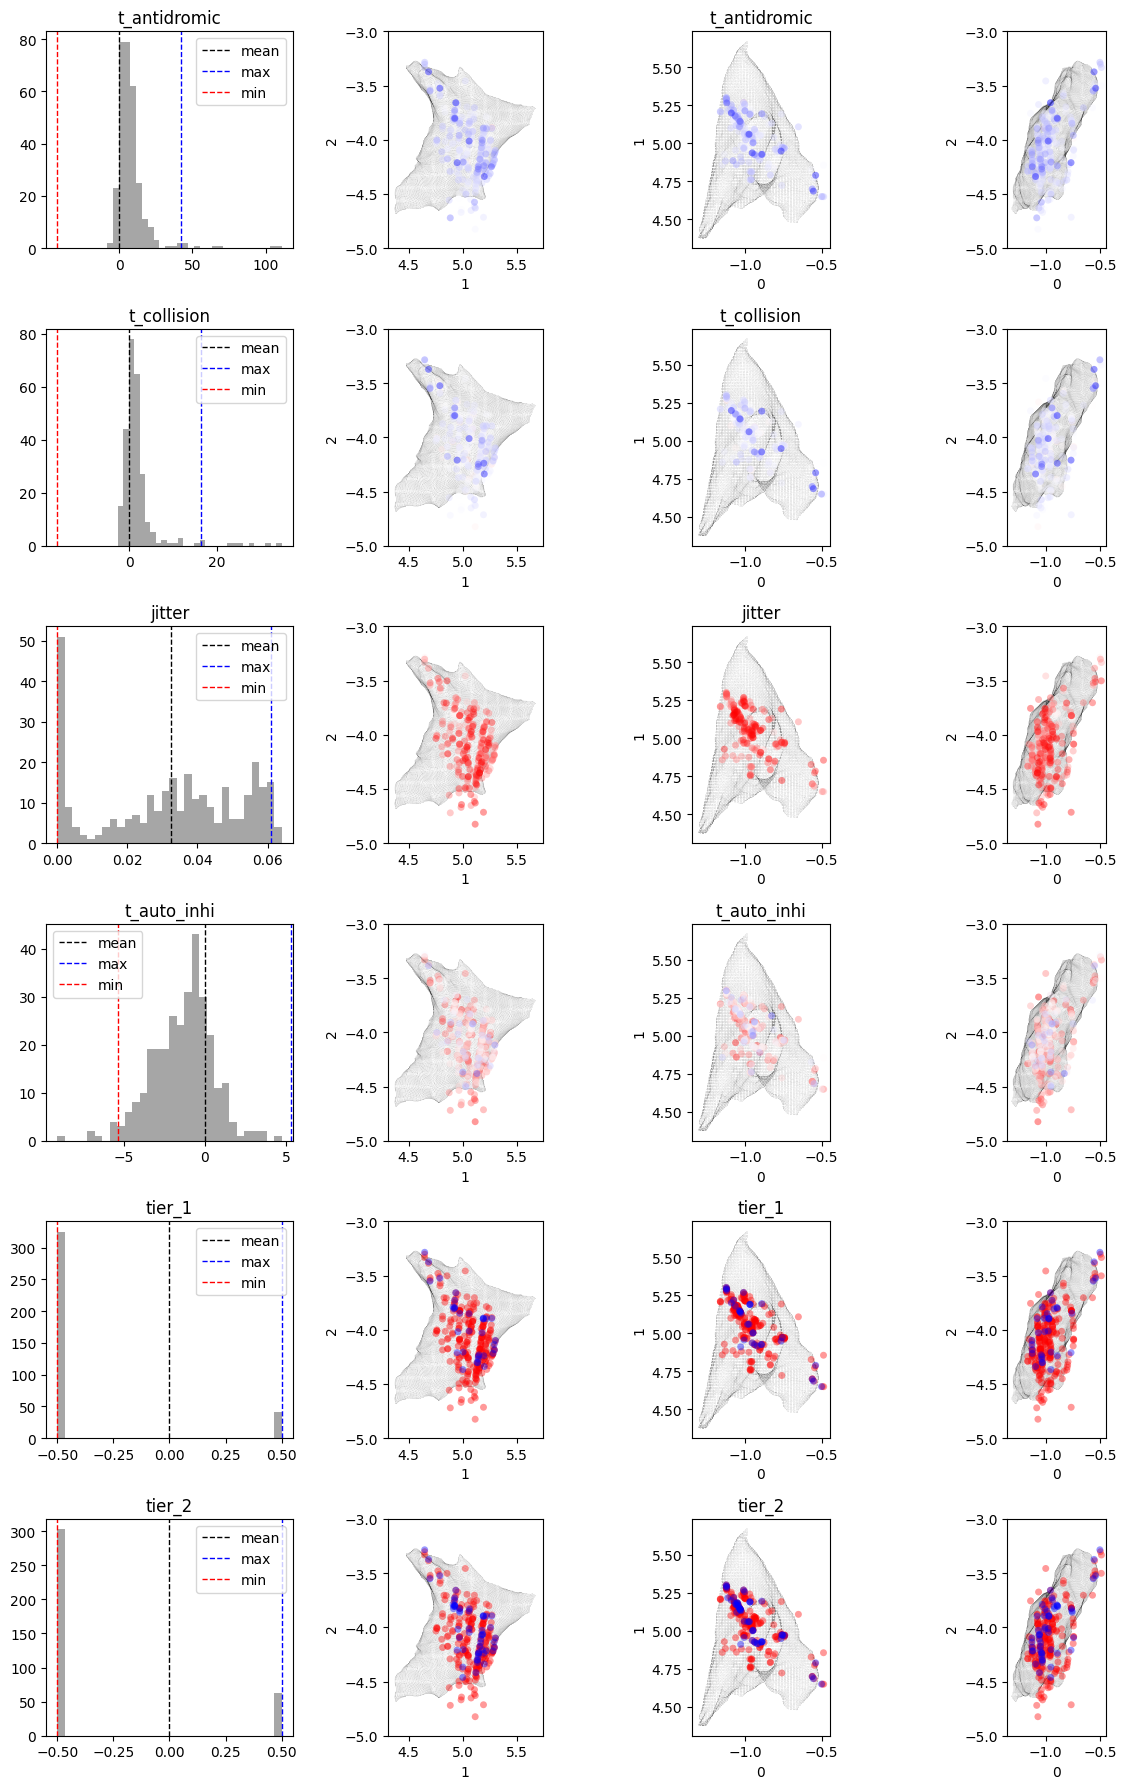

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import os

features_to_plot = ['t_antidromic', 't_collision', 'jitter', 't_auto_inhi', 'tier_1', 'tier_2']
# features_to_plot = features_beh

fig, axes = plt.subplots(len(features_to_plot), 4, figsize=(12, 3 * len(features_to_plot)))
axes = np.atleast_2d(axes)

# --- 3D anatomical points ---
ccfs = combined_df[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

for ind, feature in enumerate(features_to_plot):
    color = combined_df[feature].values.astype(float)
    color_reg = color.copy()

    # === Normalize colors to 0–1 ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        center_line = 0
        upper_limit = amp_cut
        lower_limit = -amp_cut
        # === Colormap ===
        custom_cmap = LinearSegmentedColormap.from_list(
            'blue_white_red', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.nanmin(color_reg))/(amp_cut - np.nanmin(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        center_line = np.nanmean(color)
        lower_limit = np.nanmin(np.abs(color)) * np.sign(center_line)
        upper_limit = amp_cut * np.sign(center_line)
        # === Colormap ===
        custom_cmap = LinearSegmentedColormap.from_list('white_red', [(0.0, 'white'), (1.0, 'red')])

    color_reg[np.isnan(color_reg)] = 0.5

    # === Histogram of feature values ===
    ax_hist = axes[ind, 0]
    ax_hist.hist(combined_df[feature].values, bins=30, color='gray', alpha=0.7)
    ax_hist.set_title(feature)
    ax_hist.axvline(center_line, color='k', linestyle='--', linewidth=1, label='mean')
    ax_hist.axvline(upper_limit, color='blue', linestyle='--', linewidth=1, label = 'max')
    ax_hist.axvline(lower_limit, color='red', linestyle='--', linewidth=1, label = 'min')
    ax_hist.legend()

    # # === Compute alpha scaling from rho ===
    # alpha_scale = combined_df['rho'].values[mask]
    # alpha_scale = np.sqrt(alpha_scale)               # soften scaling
    # alpha_scale = np.clip(alpha_scale, 0.2, 0.8)     # prevent extremes

    # === Sort and filter ===
    sort_ind = np.argsort(color_reg)
    ccfs_plot = ccfs[sort_ind]
    color_reg_plot = color_reg[sort_ind]
    # alpha_scale_plot = alpha_scale[sort_ind]

    # # === Precompute RGBA facecolors ===
    rgba_colors = custom_cmap(color_reg_plot)
    # rgba_colors[:, -1] = alpha_scale_plot  # inject alpha per point

    # === 2D plane projections ===
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        # background mesh outline
        ax.scatter(
            mesh_vertices_mm[:, planes[plane][0]],
            mesh_vertices_mm[:, planes[plane][1]],
            color='k', alpha=0.4, s=0.05, edgecolors='none'
        )

        # scatter the points (alpha-scaled)
        sc = ax.scatter(
            ccfs_plot[:, planes[plane][0]],
            ccfs_plot[:, planes[plane][1]],
            facecolors=rgba_colors,
            edgecolors='none',
            alpha = 0.4,
            s=25
        )

        if plane == 'hor':
            ax.set_title(feature)
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')

        if planes[plane][1] == dv:
            ax.set_ylim([-5, -3])

plt.tight_layout()
for ext in ['pdf', 'png', 'svg']:
    plt.savefig(os.path.join(beh_folder, f'antidromic_spatial_{criteria_name}.{ext}'),
                bbox_inches='tight', dpi=300)
# plt.close()


In [ ]:
import k3d
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import os

# --- Prepare mask and derived features ---
features_to_plot = ['t_antidromic', 't_collision', 'jitter', 't_auto_inhi', 'tier_1', 'tier_2']

# --- Anatomical coordinates ---
ccfs = combined_df[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ml = 0
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

for feature in features_to_plot:
    color = combined_df[feature].values.astype(float)
    color_reg = color.copy()

    # === Normalize color range to [0, 1] ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.9)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        custom_cmap = LinearSegmentedColormap.from_list(
            'bwr_custom', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.nanmin(color_reg)) / (amp_cut - np.nanmin(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        custom_cmap = LinearSegmentedColormap.from_list('wr_custom', [(0.0, 'white'), (1.0, 'red')])

    color_reg[np.isnan(color_reg)] = 0.5

    # === Sort for proper rendering ===
    sort_ind = np.argsort(color_reg)
    ccfs_plot = ccfs[sort_ind]
    color_reg_plot = color_reg[sort_ind]

    # === Map to RGBA, inject alpha ===
    rgba = custom_cmap(color_reg_plot)
    rgb = (rgba[:, :3] * 255).astype(np.uint32)
    colors = (rgb[:, 0] << 16) + (rgb[:, 1] << 8) + rgb[:, 2]

    # --- Create interactive K3D plot ---
    plt_3d = k3d.plot(
        camera_auto_fit=True,
        background_color=0x000000,
        grid_visible=False
    )

    # --- Optional: anatomical mesh if available ---
    if 'mesh_vertices_mm' in locals() and 'mesh' in locals():
        faces = np.array(mesh.faces).astype(np.uint32)
        plt_3d += k3d.mesh(
            mesh_vertices_mm.astype(np.float32),
            faces,
            color=0x888888,
            opacity=0.1
        )

    # # --- Scatter points with per-point alpha ---
    # pts = k3d.points(
    #     positions=ccfs_plot.astype(np.float32),
    #     colors=colors.astype(np.uint32),
    #     point_size=0.05,
    #     shader='3d',
    #     opacity=1.0
    # )

    for ind in range(len(ccfs_plot)):
        pt = k3d.points(
            positions=ccfs_plot[ind:ind+1].astype(np.float32),
            colors=np.array([colors[ind]]).astype(np.uint32),
            point_size=0.05,
            shader='3d',
            opacity=0.6
        )
        plt_3d += pt

    # --- Add colorbar (sample colormap directly) ---
    color_map_for_bar = np.array(
        [custom_cmap(i / 255)[:3] for i in range(256)],
        dtype=np.float32
    )

    # plt_3d += k3d.color_map.ColorMap(
    #     color_map=color_map_for_bar,
    #     color_range=[np.nanmin(color), np.nanmax(color)],
    #     label=feature,
    #     position_x=0.02,
    #     position_y=0.85,
    #     width=0.015,
    #     height=0.5
    # )

    # --- Save to HTML ---
    html_path = os.path.join(beh_folder, '3D_links_antidromic',f'k3d_{feature}_3D.html')
    os.makedirs(os.path.dirname(html_path), exist_ok=True)
    with open(html_path, 'w') as f:
        f.write(plt_3d.get_snapshot())

    print(f"✅ Saved interactive plot: {html_path}")
    # plt_3d.display()


✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/3D_links_antidromic/k3d_t_antidromic_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/3D_links_antidromic/k3d_t_collision_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/3D_links_antidromic/k3d_jitter_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/3D_links_antidromic/k3d_t_auto_inhi_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/3D_links_antidromic/k3d_tier_1_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/basic_ephys_low/3D_links_antidromic/k3d_tier_2_3D.html


In [ ]:
# grab all figures and save 
import shutil
target_folder = os.path.join(beh_folder, 'antidromic_figures')
os.makedirs(target_folder, exist_ok=True)
target_folder_t1 = os.path.join(target_folder, 'tier_1')
target_folder_t2 = os.path.join(target_folder, 'tier_2')
for row_ind, row in combined_df.iterrows():
    session = row['session']
    unit = row['unit']
    tier_1 = row['tier_1']
    tier_2 = row['tier_2']
    
    source_folder = os.path.join(session_dirs(session)['opto_dir_curated'], 'figures', 'antidromic')
    figure_name = f'{session}_unit{unit}_antidromic_analysis.png'
    source_path =  os.path.join(source_folder, figure_name)
    
    if os.path.exists(source_path):
        print(f'Found figure for {session} unit {unit}.')
        if tier_1:
            os.makedirs(target_folder_t1, exist_ok=True)
            print(f'Copying {figure_name} to tier_1 folder...')
            target_path = os.path.join(target_folder_t1, figure_name)
            shutil.copy(source_path, target_path)
        elif tier_2:
            os.makedirs(target_folder_t2, exist_ok=True)
            print(f'Copying {figure_name} to tier_2 folder...')
            target_path = os.path.join(target_folder_t2, figure_name)
            shutil.copy(source_path, target_path)

KeyboardInterrupt: 

In [ ]:
color.shape
print('Done')

Done


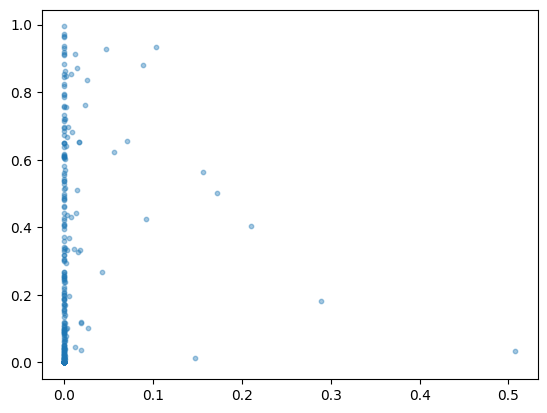

In [ ]:
plt.scatter(combined_df['p_antidromic'], combined_df['p_collision'], s= 10, alpha=0.4);